In [1]:
import pickle 
#import Analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import sys
from tqdm import tqdm
# setting path
sys.path.append('../src')
import utils_pcorr 


ModuleNotFoundError: No module named 'Preprocessing'

In [3]:
list_min_lambda = [0,0.1,1,10]
list_n_genes = [0,1,5,10,25,50,75,100]
list_ch = ['4']
#from supplementary table 1, removed EPGN because not in gene expression
set_target_genes = {'FAM13A','HHIP','BTC','NPNT','PPA2','PPM1K','TET2','NAP1L5'}


dict_params = {'gex_name':'LTRC',
               'list_pop':['case','control'],
               'list_ch':list_ch,
               'list_n_genes':list_n_genes,
               'list_min_lambda':list_min_lambda}


dir_pcorr_output = "/proj/regeps/regep00/studies/LTRC/analyses/remge/PartialCorrelation/Pcorr_output_same_cont_genes/"
df_melt_pcor_ltrc,array_pcors_ltrc,list_params_ltrc = utils_pcorr.read_data(dict_params,dir_pcorr_output)
print('Load LTRC:', df_melt_pcor_ltrc.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.94s/it]


Load LTRC: (2897216, 9)


### Figure 2: Absolute Distribution

<Figure size 1080x720 with 0 Axes>

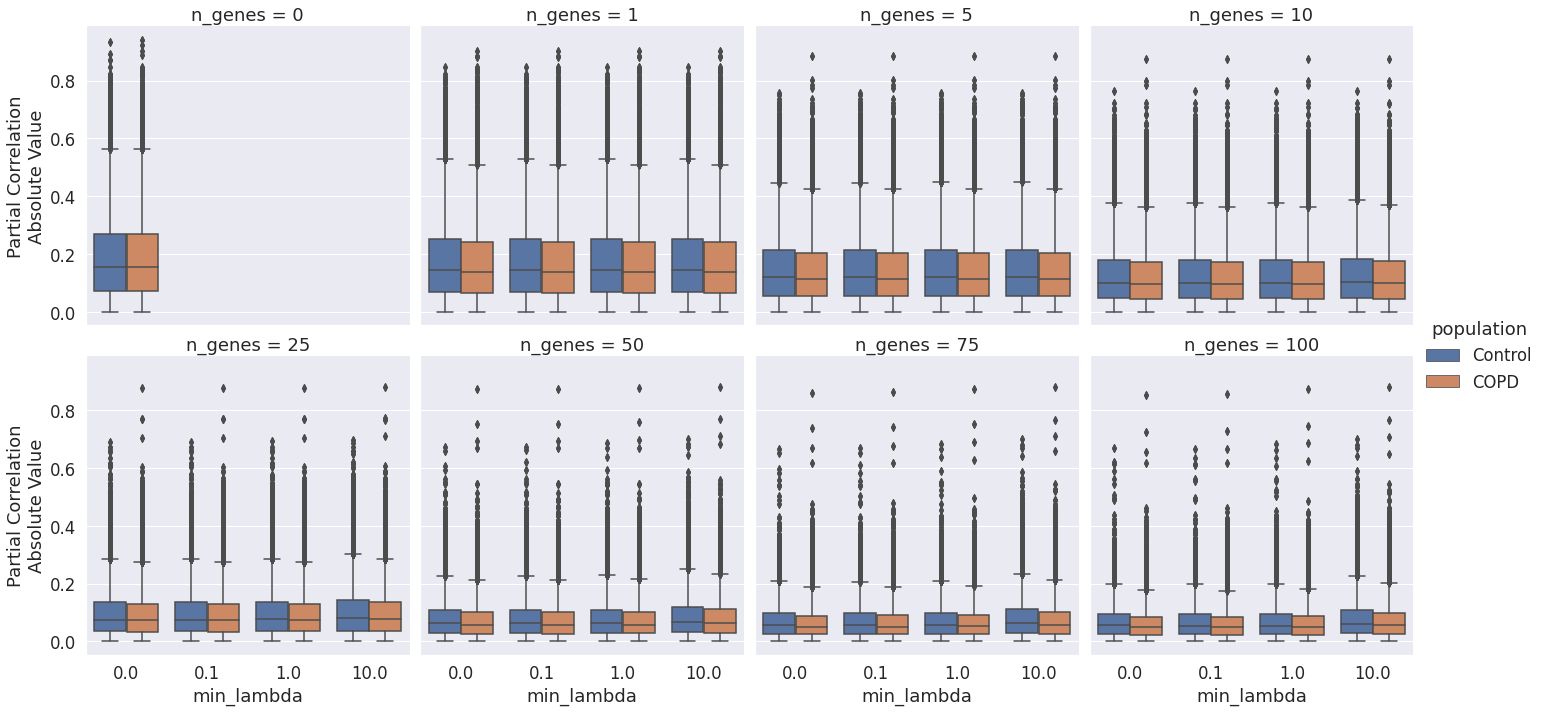

In [3]:
tmp_df_melt = df_melt_pcor_ltrc.copy()
tmp_df_melt.population = tmp_df_melt.population.map({'control':'Control','case':'COPD'})
tmp_df_melt = tmp_df_melt.rename(columns= {'value_abs':'Partial Correlation\nAbsolute Value'})
sns.set(font_scale=1.5)
plt.figure(figsize=[15,10])
sns.catplot(col="n_genes", y="Partial Correlation\nAbsolute Value",x ='min_lambda', 
            hue = 'population',kind="box",data=tmp_df_melt,col_wrap=4)

plt.savefig('../figures/Figure 2.pdf')

### Figure 3: Edges CCG genes

In [4]:
sns.set(font_scale=1.5)
set_target_genes = {'FAM13A','HHIP','BTC','NPNT','PPA2','PPM1K','TET2'}#,'GSTCD']#,'NAP1L5','EPGN']
# to have better labeling for the plot
dict_pop_name_plots_title = {'control':'Control','case':'COPD','Laval':'Laval','UBC':'UBC','GRNG':'GRNG'}
dict_pop_name_plots_xlabel = {'control':'(b)','case':'(a)','Laval':'Laval','UBC':'UBC','GRNG':'GRNG'}


def plot_edges_distr(df_melt_pcor,list_pop,ch='4'):
    plt.figure(figsize=[25,10*len(list_pop)])

    for i,tmp_pop in enumerate(list_pop):
        
        df_melt_pcor_filt = df_melt_pcor.query('n_genes>=1 and population == @tmp_pop and chromosomes==@ch and gene1 in @set_target_genes and gene2 in @set_target_genes')
        df_melt_pcor_filt = df_melt_pcor_filt.sort_values(['gene1','gene2'])
        ax = plt.subplot(len(list_pop),1,i+1)
        plt.axhline(0,c='black',linestyle='-',alpha=.5,lw=.5,zorder=0)
        plt.title(dict_pop_name_plots_title[tmp_pop],{'fontsize': 25})
        
        sns.boxplot(x="gene1", y="value", hue='gene2',data=df_melt_pcor_filt,ax=ax,hue_order = list(set_target_genes),order = list(set_target_genes))
        
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        ax.xaxis.grid(True, which='minor', color='black', lw=1,linestyle='--')
        plt.xlabel(dict_pop_name_plots_xlabel[tmp_pop],{'fontsize': 30})
        plt.ylabel('Partial Correlation',{'fontsize': 25})
        xlabel_order = [x.get_text() for x in plt.xticks()[1]]
        plt.legend(ncol=len(set_target_genes), fancybox=True, shadow=True, prop={'size': 20},loc='upper center')
        plt.axhline(0,c='black',linestyle='dashed',alpha=.3)
    plt.subplots_adjust(hspace=.3)
    
    

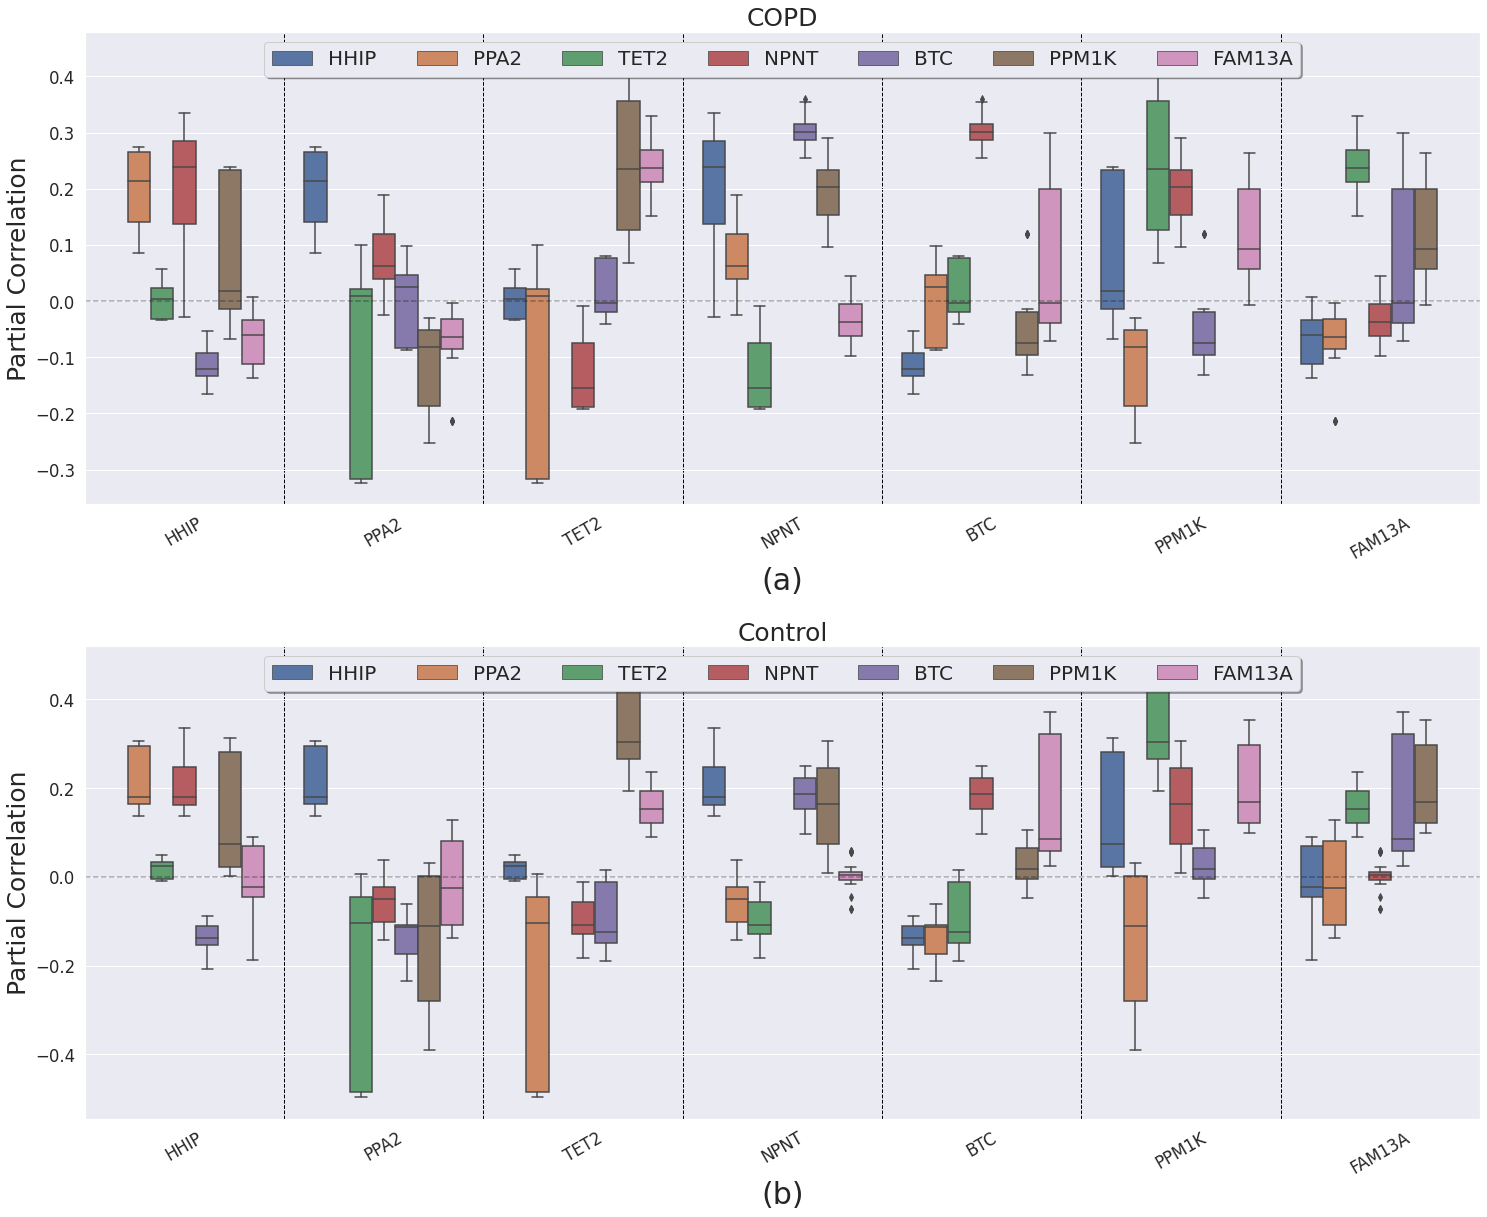

In [5]:
plot_edges_distr(df_melt_pcor_ltrc,['case', 'control'],ch='4')
plt.savefig('../figures/Figure 3.pdf')

### S. Figure 2:  GSE population 

In [6]:
list_gse_pop = ['GSE23352','GSE23529','GSE23545']

dict_params = {'gex_name':'GSE',
               'list_pop':list_gse_pop,
               'list_ch':list_ch,
               'list_n_genes':list_n_genes,
               'list_min_lambda':list_min_lambda}

df_melt_pcor_gse,array_pcors_gse,list_params_gse = utils_pcorr.read_data(dict_params,dir_pcorr_output)
# rename the GSE population names
dict_pop_map_gse = {'GSE23352':'Laval','GSE23529':'UBC','GSE23545':'GRNG'}
df_melt_pcor_gse.population = df_melt_pcor_gse.population.map(dict_pop_map_gse)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.42s/it]


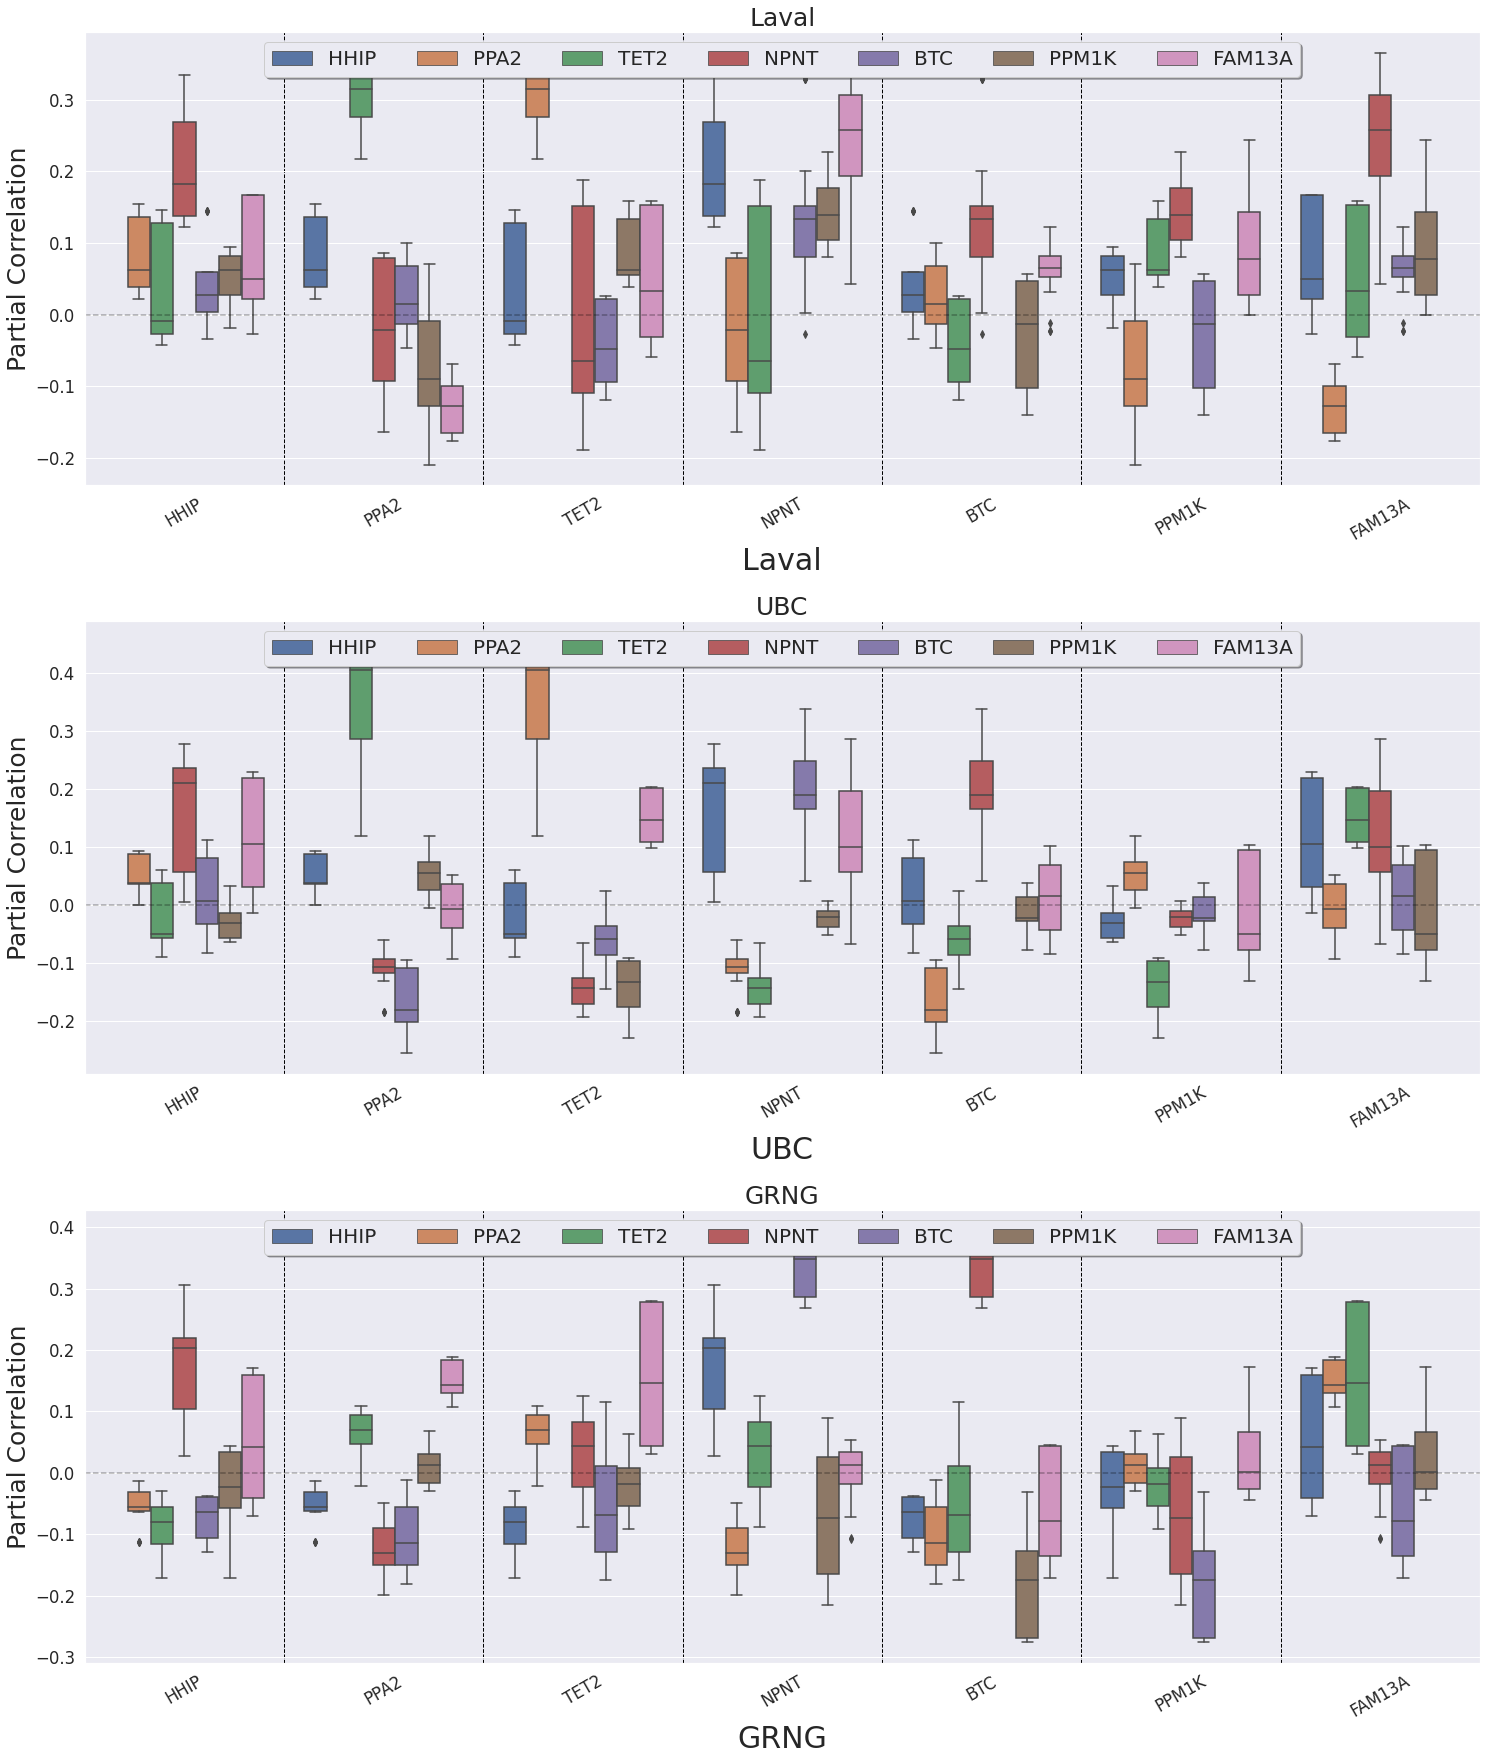

In [7]:
plot_edges_distr(df_melt_pcor_gse,dict_pop_map_gse.values(),ch='4')
plt.savefig('../figures/S. Figure 2.pdf')

### SUPPLEMENTARY TABLE

In [8]:
from IPython.display import display, HTML
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_edge_info(x):
    median = str(x.median().round(2))
    interval_quant = str([x.quantile(0.25).round(2),x.quantile(0.75).round(2)])
    return median + '\n' + interval_quant

def get_mediand_edges(df):
    tmp_df = df.query('gene1<gene2 and gene1 in @set_target_genes and gene2 in @set_target_genes')
    tmp_df = pd.DataFrame(tmp_df.groupby(['edge','population']).value.apply(get_edge_info)).reset_index()
    return tmp_df.pivot(columns='population',index='edge',values='value')
    
tmp_df_ltrc = get_mediand_edges(df_melt_pcor_ltrc.query('population in ["case","control"]'))
tmp_df_gse = get_mediand_edges(df_melt_pcor_gse)
df_median_edges = pd.concat([tmp_df_ltrc,tmp_df_gse],axis=1)
df_median_edges.to_csv('../tables/Table S2 Min_Max_edges.csv')
pretty_print(df_median_edges)

population,case,control,GRNG,Laval,UBC
edge,,,,,
BTC-FAM13A,"-0.0[-0.04, 0.2]","0.09[0.06, 0.32]","-0.08[-0.13, 0.04]","0.07[0.05, 0.08]","0.02[-0.04, 0.07]"
BTC-HHIP,"-0.12[-0.13, -0.08]","-0.13[-0.15, -0.1]","-0.06[-0.11, -0.04]","0.03[0.0, 0.06]","0.01[-0.03, 0.08]"
BTC-NPNT,"0.3[0.29, 0.31]","0.18[0.15, 0.22]","0.34[0.27, 0.37]","0.13[0.08, 0.16]","0.19[0.17, 0.25]"
BTC-PPA2,"0.03[-0.08, 0.04]","-0.11[-0.17, -0.11]","-0.11[-0.15, -0.04]","0.02[-0.01, 0.07]","-0.18[-0.2, -0.11]"
BTC-PPM1K,"-0.07[-0.1, -0.02]","0.02[-0.0, 0.07]","-0.17[-0.27, -0.13]","-0.01[-0.1, 0.05]","-0.02[-0.03, 0.01]"
BTC-TET2,"-0.0[-0.02, 0.08]","-0.11[-0.15, -0.01]","-0.06[-0.13, 0.01]","-0.05[-0.09, 0.02]","-0.06[-0.09, -0.04]"
FAM13A-HHIP,"-0.06[-0.11, -0.03]","-0.02[-0.04, 0.07]","0.04[-0.04, 0.16]","0.05[0.02, 0.17]","0.11[0.04, 0.22]"
FAM13A-NPNT,"-0.04[-0.06, -0.0]","0.01[-0.01, 0.01]","0.02[-0.01, 0.04]","0.26[0.19, 0.31]","0.1[0.06, 0.2]"
FAM13A-PPA2,"-0.08[-0.09, -0.03]","-0.03[-0.11, 0.08]","0.15[0.13, 0.19]","-0.12[-0.16, -0.1]","-0.01[-0.04, 0.04]"
